In [1]:
cd D:\\Saarbrucken\\EDA_Research\\vae-disentanglement\\disentanglement_lib_pl

D:\Saarbrucken\EDA_Research\vae-disentanglement\disentanglement_lib_pl


## Keeping everything else (bs, LR, w_recon, w_sup, prior type etc.) the same we just varied w_kld = 5,10,15,20,25

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from matplotlib import cm as mpl_colormaps
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import torch
import torchvision.utils as vutils
import torchvision.transforms.functional as T
from torch.utils.data import DataLoader
from torchvision import transforms

import models
from common.data_loader import DSpritesDataset, ThreeShapesDataset, ContinumDataset
#from common import notebook_utils
from common import utils
#from common.notebook_utils import *
from common import notebook_utils as nbutils
from common.utils import CenteredNorm
from gnncsvae_experiment import GNNCSVAEExperiment
from common.ops import reparametrize
# Change figure aesthetics
%matplotlib inline
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})
np.set_printoptions(suppress=True,precision=4)

In [3]:
# these two will be used any time we load a saved checkppoint

PROJECT_ROOT = r"D:\Saarbrucken\EDA_Research\vae-disentanglement"
datapath = os.path.join(PROJECT_ROOT, "datasets")
os.environ['DISENTANGLEMENT_LIB_DATA'] = datapath

ModelParams = namedtuple('ModelParams', ["z_dim", "l_dim", "num_labels" , "in_channels", 
                                        "image_size", "batch_size", "w_recon", "w_kld", "w_sup_reg", "kl_warmup_epochs",
                                         "adjacency_matrix", "loss_terms", "use_loss_weights",
                                        "controlled_capacity_increase", "iterations_c", "max_capacity", "dset_name", 
                                         "num_indept_nodes"
                                        ])

ExpParams = dict(
        in_channels=-1,
        image_size=64,
        LR=1e-4,
        weight_decay=0.0,       
        dataset=None,
        datapath=datapath,
        droplast=True,        
        batch_size=64,
        num_workers=0,
        pin_memory=False,
        seed=123,
        evaluation_metrics=None,
        visdom_on=False,
        save_dir=None,
        max_epochs=1,
        l_zero_reg=False
)

# KDL = 5

In [5]:
# load the learned model here

algo_name = "GNNBasedConceptStructuredVAE"
checkpoint_path = os.path.join(PROJECT_ROOT, "models", "pendulum_kld_test", "pendulum208wkld5.ckpt")
z_dim = 1
channels = 3
l_dim = 4
num_nodes = 4
num_indept_nodes = 0
dataset_name = "pendulum"
current_device = torch.device("cuda:0")

# prep params
model_params = ModelParams(
        [z_dim], l_dim, 0, channels, 64, 64, 0.80, 0.15, 1.0, 0,
        os.path.join(PROJECT_ROOT, "adjacency_matrices", f"{dataset_name}.pkl"),
        ['aux_classification'], False,
        False, 0, 0, "pendulum", num_indept_nodes
)

ExpParams['channels'] = channels

# load model
print("Loading model")
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=ExpParams,
            dataset_params=None).to(current_device)


Loading model
Posterior mat:  tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 0., 1.]])
Prior mat:  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]]
GT based prior:  True
GNNBasedConceptStructuredVAE Model Initialized
Loading dataset:  pendulum


In [15]:
print("Loading dataset: ", dataset_name)
dataset = nbutils.get_configured_dataset(dataset_name)
sample_loader = DataLoader(dataset, batch_size=64, shuffle = True, drop_last=True)

Loading dataset:  pendulum


# Is there any pattern in the training behaviour?

TODO:

# Learned Prior activations

In [9]:
prior_mu_batches, gt_batches = nbutils.get_prior_mus_given_gt_labels(sample_loader, vae_model, l_dim, current_device,64, batches=None)

print(prior_mu_batches.shape, gt_batches.shape)

(7296, 4) (7296, 4)


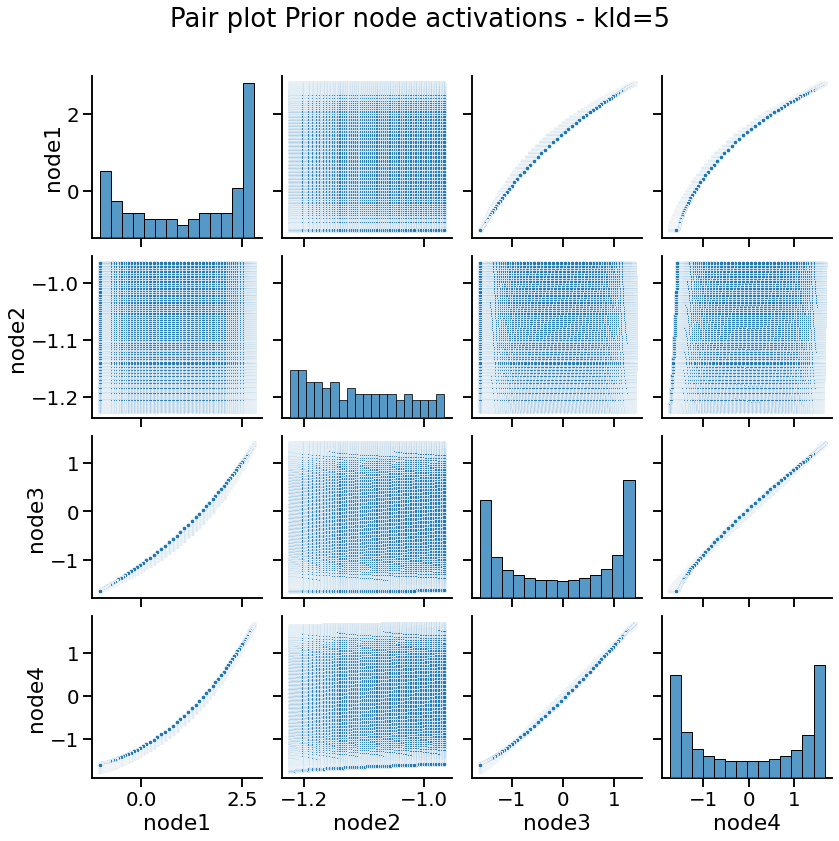

In [10]:
# plot prior activations
# assuming it has only 1-dim
activations_df = pd.DataFrame(prior_mu_batches, columns=["node1","node2","node3","node4"])
activations_df.head()
sns_plot = sns.pairplot(activations_df, markers=".", height=3.0)
sns_plot.fig.suptitle("Pair plot Prior node activations - kld=5")
sns_plot.fig.subplots_adjust(top=0.9)

# Learned Posterior activations

In [11]:
# get activations generated by the images in dataset
mu_batches, label_batches = nbutils.csvaegnn_get_latent_activations_with_labels_for_scatter(vae_model, sample_loader, 
                                                                                    current_device, batches = 110)

print(mu_batches.shape, label_batches.shape)

(7040, 4, 1) (7040, 4)


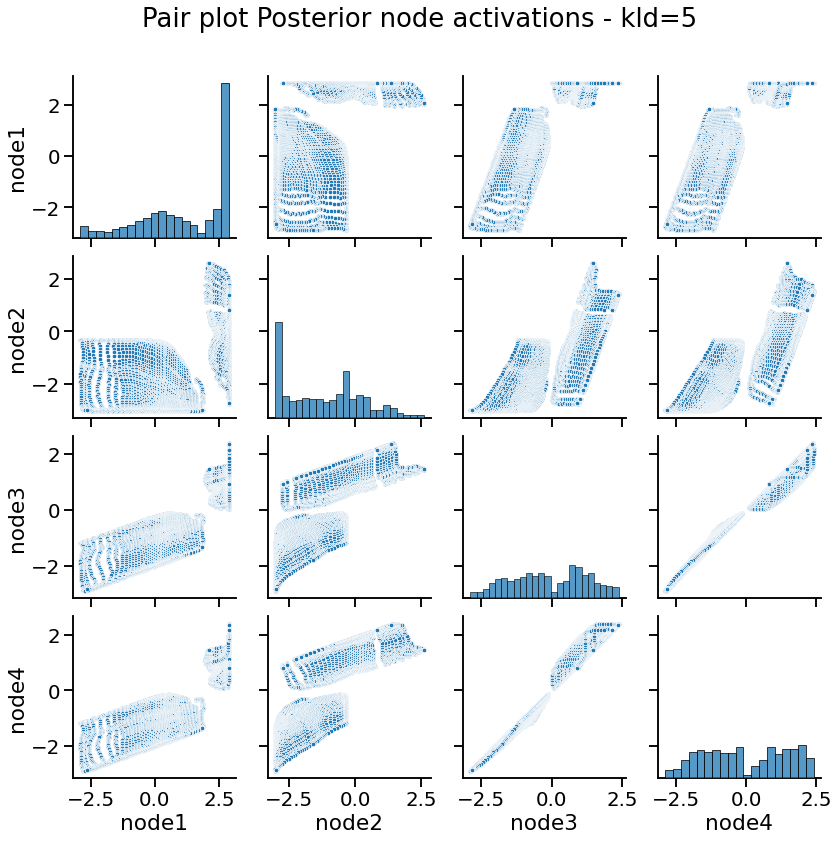

In [12]:
# plot prior activations
# suppress the feat_dim dimension from (b,V,feat_dim) assuming it has only 1-dim
activations = mu_batches.squeeze(2)
activations_df = pd.DataFrame(activations, columns=["node1","node2","node3","node4"])
activations_df.head()
sns_plot = sns.pairplot(activations_df, markers=".", height=3.0)
sns_plot.fig.suptitle("Pair plot Posterior node activations - kld=5")
sns_plot.fig.subplots_adjust(top=0.9)

# Fixed value interventions at all levels?

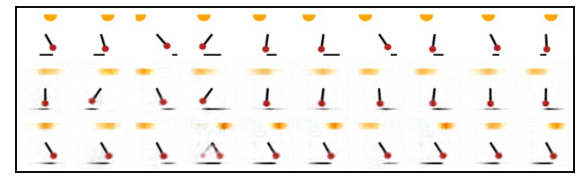

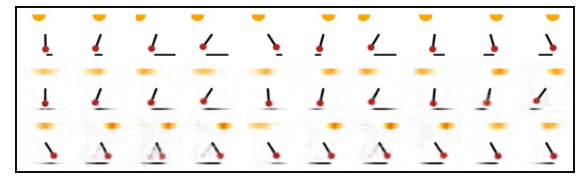

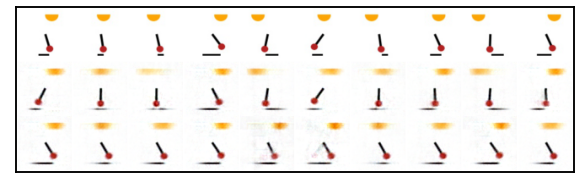

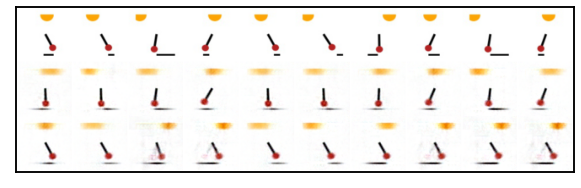

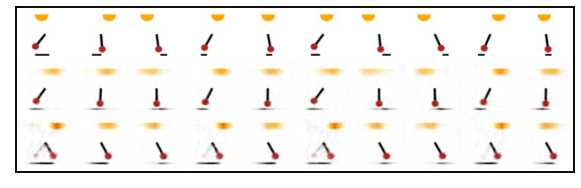

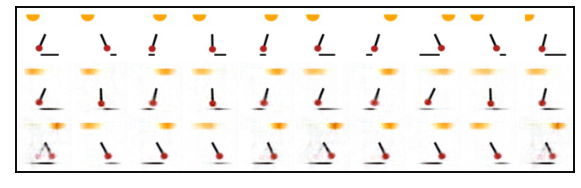

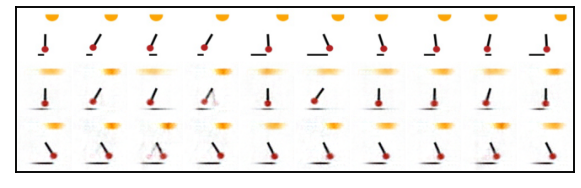

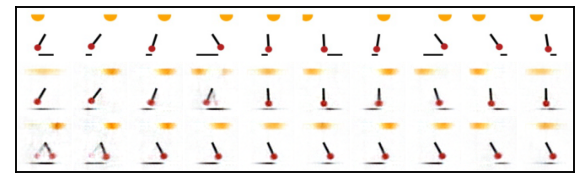

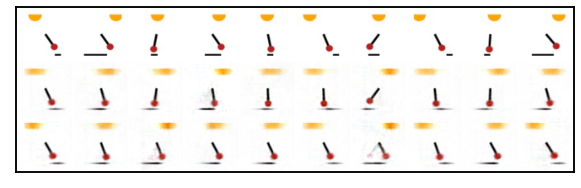

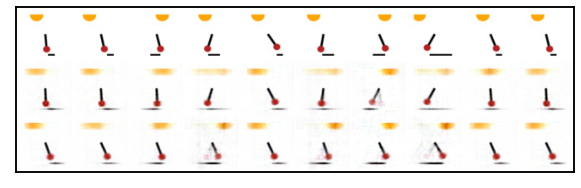

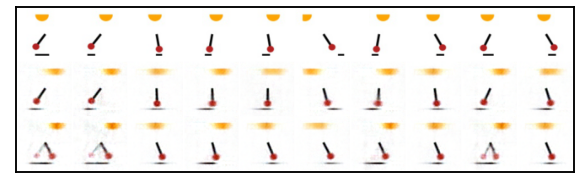

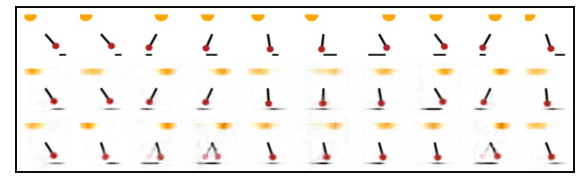

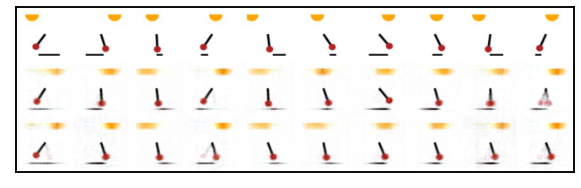

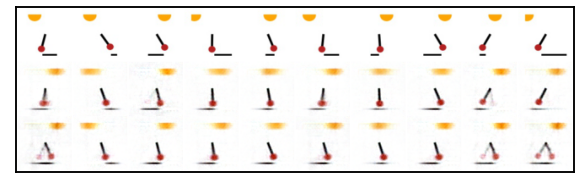

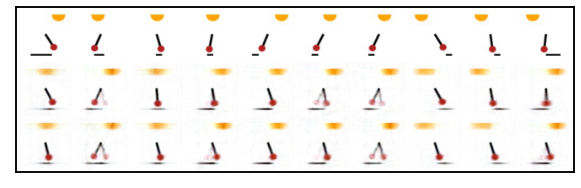

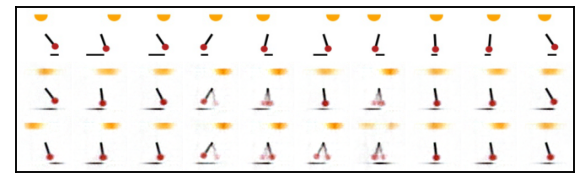

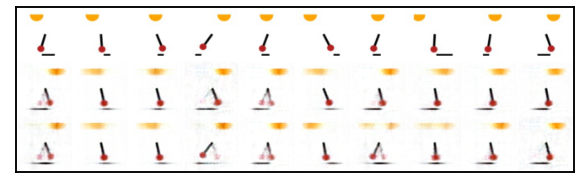

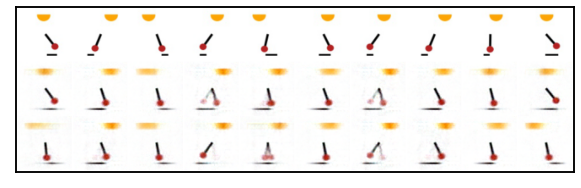

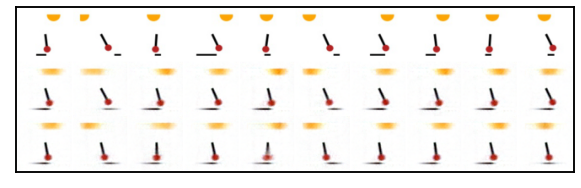

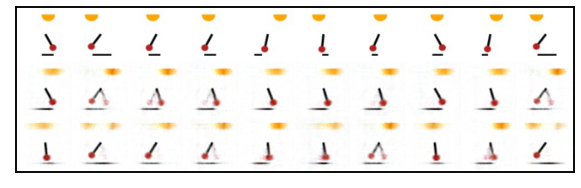

In [32]:
from collections import defaultdict

# node 0 - move the light source and pendulum to the right, turn light on
# (switch_state, light_state, pendulum angle, light pos)
# forgets shadow
node_idx = 0
num_samples = 10
intervention_levels = [0,1]


#def get_intervention_output_image(vae_model, input_x, intervention_level, intervention_node, intervention_value):
    
for node_value in np.arange(-1.0,1.0,0.1):   
    
    images, labels = next(sample_loader.__iter__())
    bs = images.size()[0]
    
    intervened_images = defaultdict(list)
    orig_images = []
    
    # for every fixed value C, we apply it as intervention to num_samples images
    for _ in range(num_samples):
        
        x = images[np.random.choice(bs)].unsqueeze(0).to(current_device)
        orig_images.append(x)
        
        for int_lvl in intervention_levels:
            
            x_intervened = nbutils.csvaegnn_intervene_upper_layers(vae_model, x, intervention_level=int_lvl, 
                                                    intervention_nodes=node_idx, intervention_values=[node_value])[0]
        
            intervened_images[int_lvl].append(x_intervened)
    
    
    #print(intervened_images.keys())
    stacked_images = []
    # stack of original images - top row
    stacked_images.append(torch.stack([o_img.squeeze(0) for o_img in orig_images], dim=0))
    
    for int_lvl in intervention_levels:
        # stack of traversed images at each gnn layer level in order
        stacked_images.append(torch.stack([t_img.squeeze(0) for t_img in intervened_images[int_lvl]], dim=0))
    
    comparison_visual = torch.cat(stacked_images, dim=2)
    
    img_grid = vutils.make_grid(comparison_visual, normalize=True, nrow=num_samples, value_range=(0.0,1.0), pad_value=1.0)
    nbutils.show_image_grid_pt(img_grid, figsize=(10,10))

In [ ]:
# hold same set images and show const intervention effect at each gnn layer level
# use prior to 'intervene'?

In [54]:
def csvaegnn_intervene_final_layer(vae_model, x, intervention_nodes, intervention_values):
    """
    Function assumes 1-d latent space for node features

    """
    
    samples = []
    
    with torch.no_grad():
        
        mu, logvar, z = vae_model.encode(x)
        z_sample = reparametrize(mu, logvar)

        amputated_mat = vae_model.dept_adjacency_matrix
        amputated_mat[intervention_nodes] = torch.zeros(amputated_mat.size()[0])
        amputated_mat[intervention_nodes, intervention_nodes] = 1.0
        amputated_mat = amputated_mat.to(x.device)
        
        #print(amputated_mat)

        for intervention_value in intervention_values:
            
            z_sample = z.clone()
            z_sample[:, intervention_nodes, 0] = intervention_value

            # apply amputated matrix to transfer effects
            #z_sample = torch.matmul(amputated_mat, z_sample)
            # intervention has propagated, now we can recon
            z_flattened = vae_model.flatten_node_features(z_sample)
            sample = vae_model.decode(z_flattened).data

            samples.append(sample)

    return samples

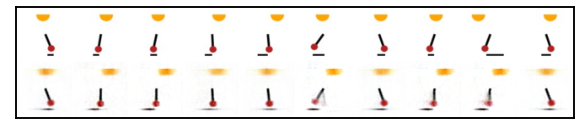

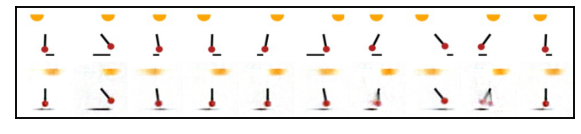

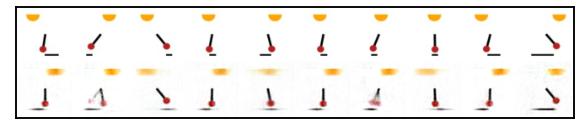

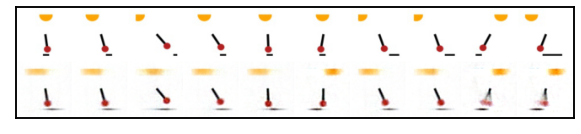

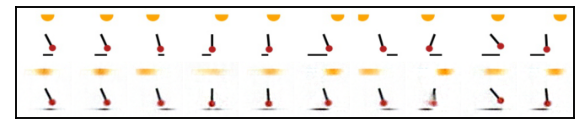

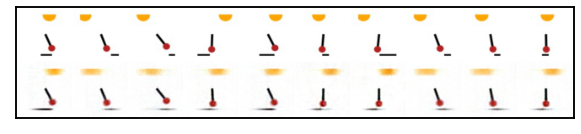

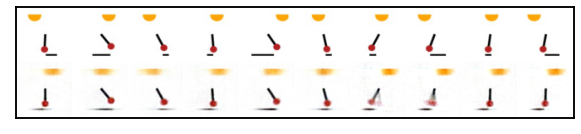

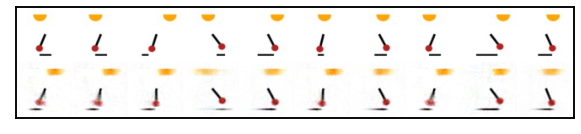

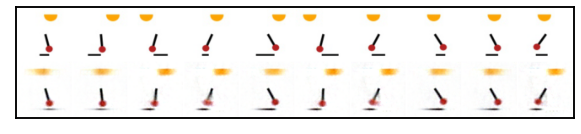

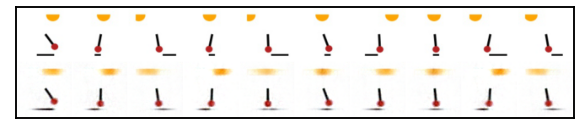

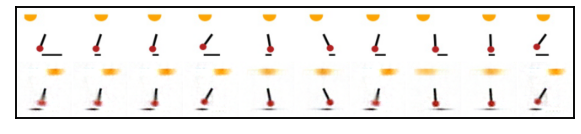

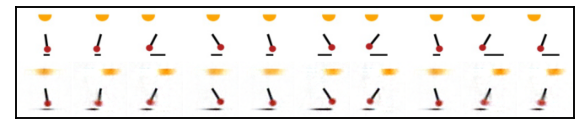

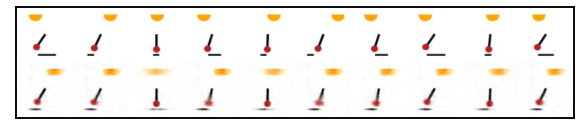

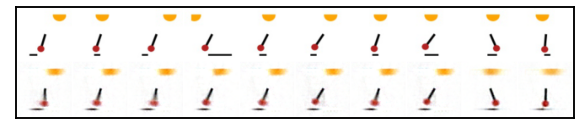

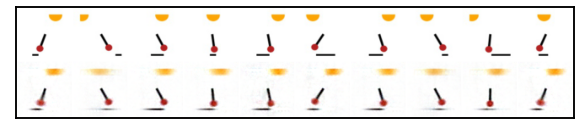

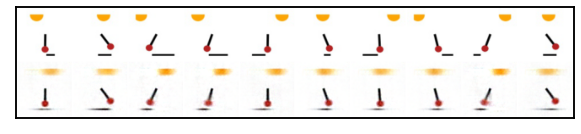

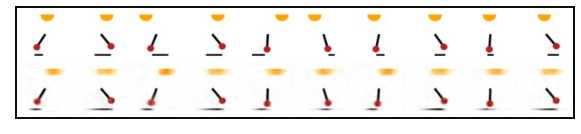

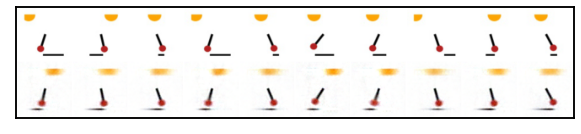

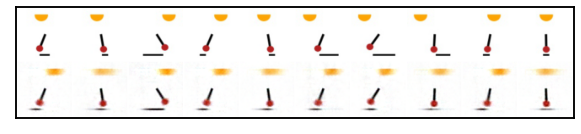

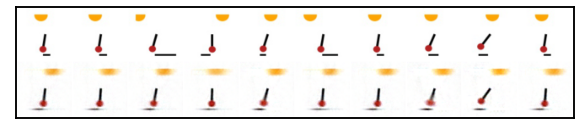

In [61]:
from collections import defaultdict

# node 0 - move the light source and pendulum to the right, turn light on
# (switch_state, light_state, pendulum angle, light pos)
# forgets shadow
node_idx = 3
num_samples = 10
    
for node_value in np.arange(-2.0,0.0,0.1):   
    
    images, labels = next(sample_loader.__iter__())
    bs = images.size()[0]
    
    intervened_images = []
    orig_images = []
    
    # for every fixed value C, we apply it as intervention to num_samples images
    for _ in range(num_samples):
        
        x = images[np.random.choice(bs)].unsqueeze(0).to(current_device)
        orig_images.append(x)
        
        x_intervened = csvaegnn_intervene_final_layer(vae_model, x, node_idx, intervention_values=[node_value])[0] 
        intervened_images.append(x_intervened)
    
    
    #print(intervened_images.keys())
    stacked_images = []
    # stack of original images - top row
    stacked_images.append(torch.stack([o_img.squeeze(0) for o_img in orig_images], dim=0))
    
    #for int_lvl in intervention_levels:
        # stack of traversed images at each gnn layer level in order
    stacked_images.append(torch.stack([t_img.squeeze(0) for t_img in intervened_images], dim=0))
    
    comparison_visual = torch.cat(stacked_images, dim=2)
    
    img_grid = vutils.make_grid(comparison_visual, normalize=True, nrow=num_samples, value_range=(0.0,1.0), pad_value=1.0)
    nbutils.show_image_grid_pt(img_grid, figsize=(10,10))

Visualizing latent space from -1.78 to 4.32, with center at 3.05


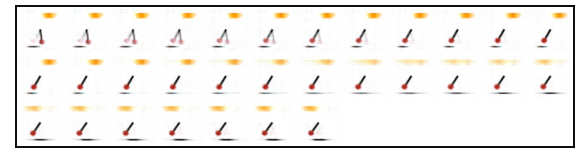

In [74]:
images, labels = next(sample_loader.__iter__())
ref_img = images[20].unsqueeze(0).to(current_device)

traversed_images = nbutils.csvaegnn_do_latent_traversal_scatter(vae_model, ref_img, limit=3, inter=1/5, 
                                        node_to_explore=3, dim_to_explore=0, mode='relative', 
                                        lb=None, ub=None, fix_dim=None, fix_val=None)

traversed_images_stacked = torch.stack([t_img.squeeze(0) for t_img in traversed_images], dim=0)
img_grid = vutils.make_grid(traversed_images_stacked, normalize=True, nrow=12, value_range=(0.0,1.0), pad_value=1.0)
nbutils.show_image_grid_pt(img_grid, figsize=(10,10))

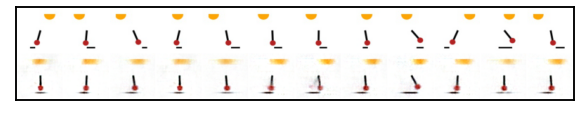

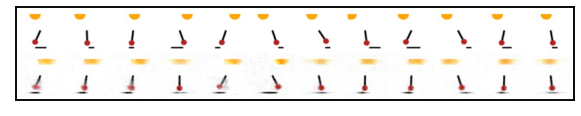

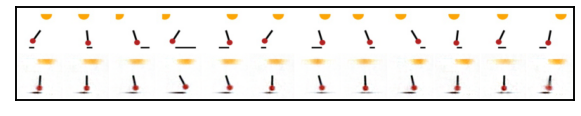

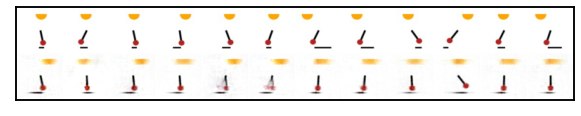

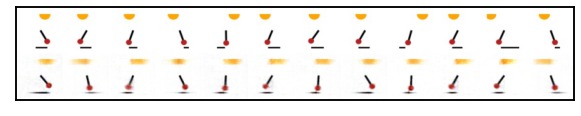

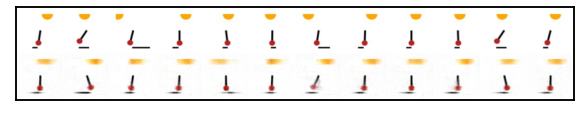

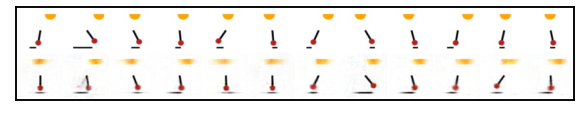

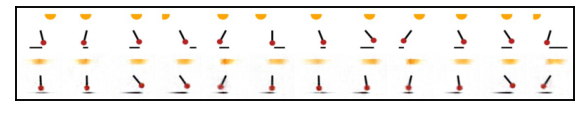

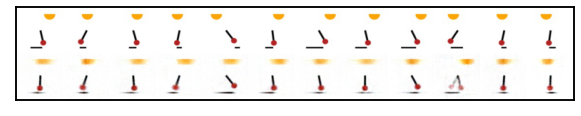

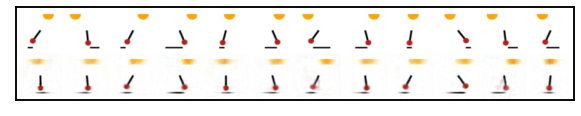

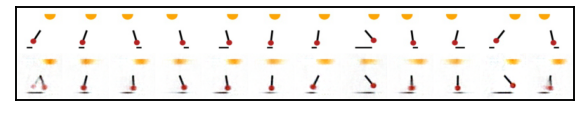

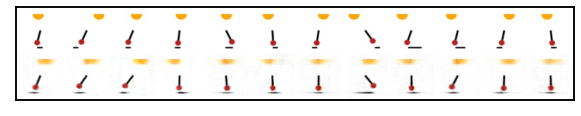

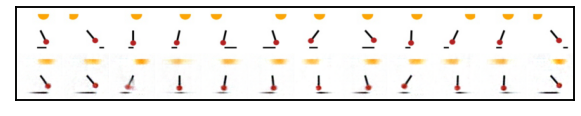

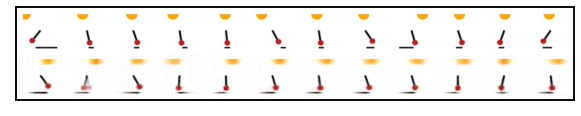

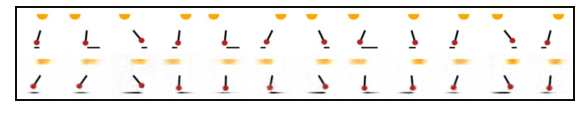

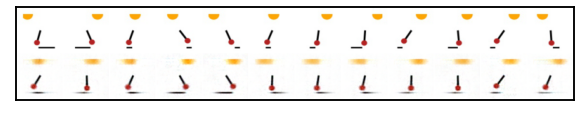

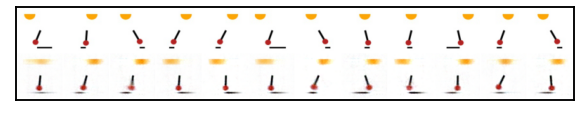

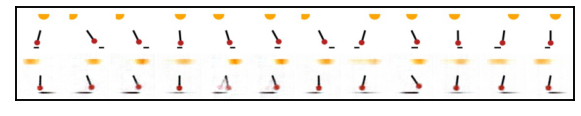

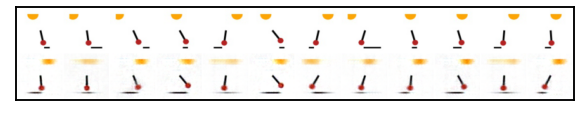

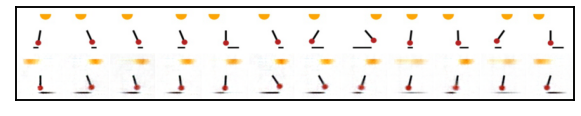

In [84]:
# const interv recons
node_idx = 2
num_samples = 12
    
for node_value in np.arange(-2.0,2.0,0.2):   
    
    images, labels = next(sample_loader.__iter__())
    bs = labels.size()[0]
    
    intervened_images = []
    orig_images = []
    
    # for every fixed value C, we apply it as intervention to num_samples images
    for _ in range(num_samples):
        
        rnd_sample = np.random.choice(bs)
        
        label = labels[rnd_sample].unsqueeze(0).to(current_device)
        orig_images.append(images[rnd_sample].unsqueeze(0).to(current_device))
        
        prior_mu, prior_logvar = vae_model.prior_to_latents_prediction(current_device, label)
        z_sample = reparametrize(prior_mu, prior_logvar)
        
        z_sample[:, node_idx, 0] = node_value
        z_flattened = vae_model.flatten_node_features(z_sample)
        x_intervened = vae_model.decode(z_flattened).data
        
        intervened_images.append(x_intervened)
    
    #print(intervened_images.keys())
    stacked_images = []
    # stack of original images - top row
    stacked_images.append(torch.stack([o_img.squeeze(0) for o_img in orig_images], dim=0))
    
    #for int_lvl in intervention_levels:
        # stack of traversed images at each gnn layer level in order
    stacked_images.append(torch.stack([t_img.squeeze(0) for t_img in intervened_images], dim=0))
    
    comparison_visual = torch.cat(stacked_images, dim=2)
    
    img_grid = vutils.make_grid(comparison_visual, normalize=True, nrow=num_samples, value_range=(0.0,1.0), pad_value=1.0)
    nbutils.show_image_grid_pt(img_grid, figsize=(10,10))

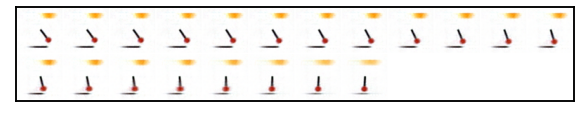

In [99]:
# Prior - random image traversals recons
node_idx = 0
num_samples = 12

#images, labels = next(sample_loader.__iter__())
#bs = labels.size()[0]

intervened_images = []
orig_images = []


rnd_sample = 18 #np.random.choice(bs)
label = labels[rnd_sample].unsqueeze(0).to(current_device)
orig_images.append(images[rnd_sample].unsqueeze(0).to(current_device))

prior_mu, prior_logvar = vae_model.prior_to_latents_prediction(current_device, label)
z_sample = reparametrize(prior_mu, prior_logvar)

for node_value in np.arange(-2.0,2.0,0.2):
    z_sample[:, node_idx, 0] = node_value
    z_flattened = vae_model.flatten_node_features(z_sample)
    x_intervened = vae_model.decode(z_flattened).data

    intervened_images.append(x_intervened)


comparison_visual = torch.stack([t_img.squeeze(0) for t_img in intervened_images], dim=0)

img_grid = vutils.make_grid(comparison_visual, normalize=True, nrow=num_samples, value_range=(0.0,1.0), pad_value=1.0)
nbutils.show_image_grid_pt(img_grid, figsize=(10,10))

In [91]:
rnd_sample

18

# KLD = 25

In [100]:
# load the learned model here

algo_name = "GNNBasedConceptStructuredVAE"
checkpoint_path = os.path.join(PROJECT_ROOT, "models", "pendulum_kld_test", "pendulum223wkld25.ckpt")
z_dim = 1
channels = 3
l_dim = 4
num_nodes = 4
num_indept_nodes = 0
dataset_name = "pendulum"
current_device = torch.device("cuda:0")

# prep params
model_params = ModelParams(
        [z_dim], l_dim, 0, channels, 64, 64, 0.80, 0.15, 1.0, 0,
        os.path.join(PROJECT_ROOT, "adjacency_matrices", f"{dataset_name}.pkl"),
        ['aux_classification'], False,
        False, 0, 0, "pendulum", num_indept_nodes
)

ExpParams['channels'] = channels

# load model
print("Loading model")
vae_model_class = getattr(models, algo_name)
vae_model = vae_model_class(model_params)

vae_experiment = GNNCSVAEExperiment.load_from_checkpoint(
            checkpoint_path,
            vae_model=vae_model, 
            params=ExpParams,
            dataset_params=None).to(current_device)


Loading model
Posterior mat:  tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 0., 1.]])
Prior mat:  [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [1. 1. 0. 0.]
 [1. 1. 0. 0.]]
GT based prior:  True
GNNBasedConceptStructuredVAE Model Initialized


In [101]:
print("Loading dataset: ", dataset_name)
dataset = nbutils.get_configured_dataset(dataset_name)
sample_loader = DataLoader(dataset, batch_size=64, shuffle = True, drop_last=True)

Loading dataset:  pendulum


# Learned Prior activations

In [102]:
# get activations generated by the images in dataset
mu_batches, label_batches = nbutils.csvaegnn_get_latent_activations_with_labels_for_scatter(vae_model, sample_loader, 
                                                                                    current_device, batches = 110)

print(mu_batches.shape, label_batches.shape)

(7040, 4, 1) (7040, 4)


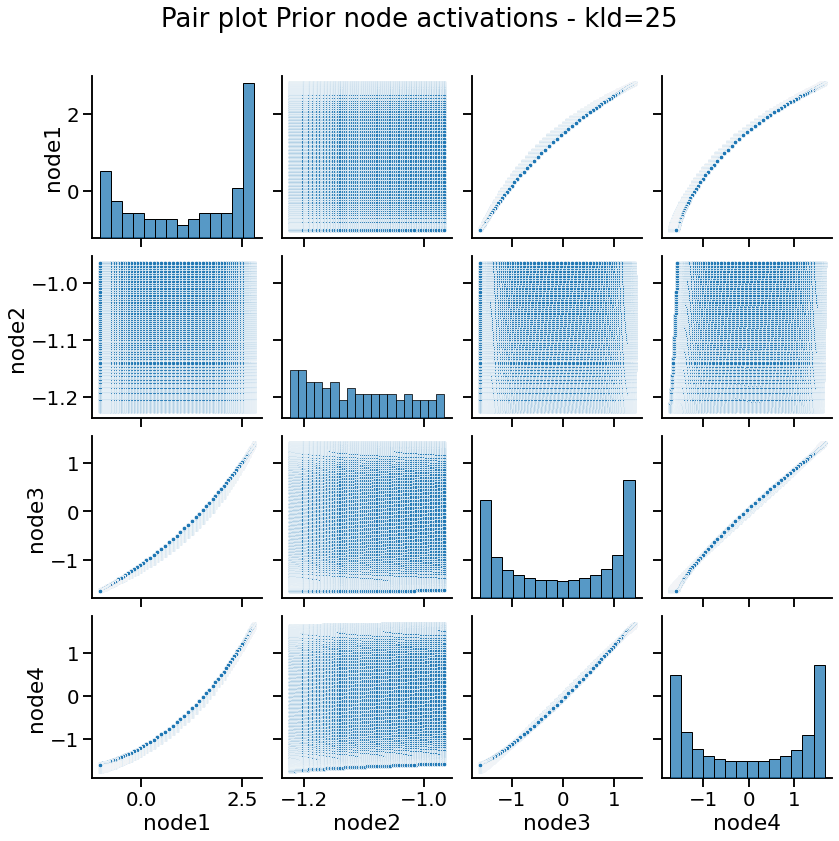

In [104]:
# plot prior activations
# assuming it has only 1-dim
activations_df = pd.DataFrame(prior_mu_batches, columns=["node1","node2","node3","node4"])
activations_df.head()
sns_plot = sns.pairplot(activations_df, markers=".", height=3.0)
sns_plot.fig.suptitle("Pair plot Prior node activations - kld=25")
sns_plot.fig.subplots_adjust(top=0.9)

# Learned posterior activations

In [105]:
# get activations generated by the images in dataset
mu_batches, label_batches = nbutils.csvaegnn_get_latent_activations_with_labels_for_scatter(vae_model, sample_loader, 
                                                                                    current_device, batches = 110)

print(mu_batches.shape, label_batches.shape)

(7040, 4, 1) (7040, 4)


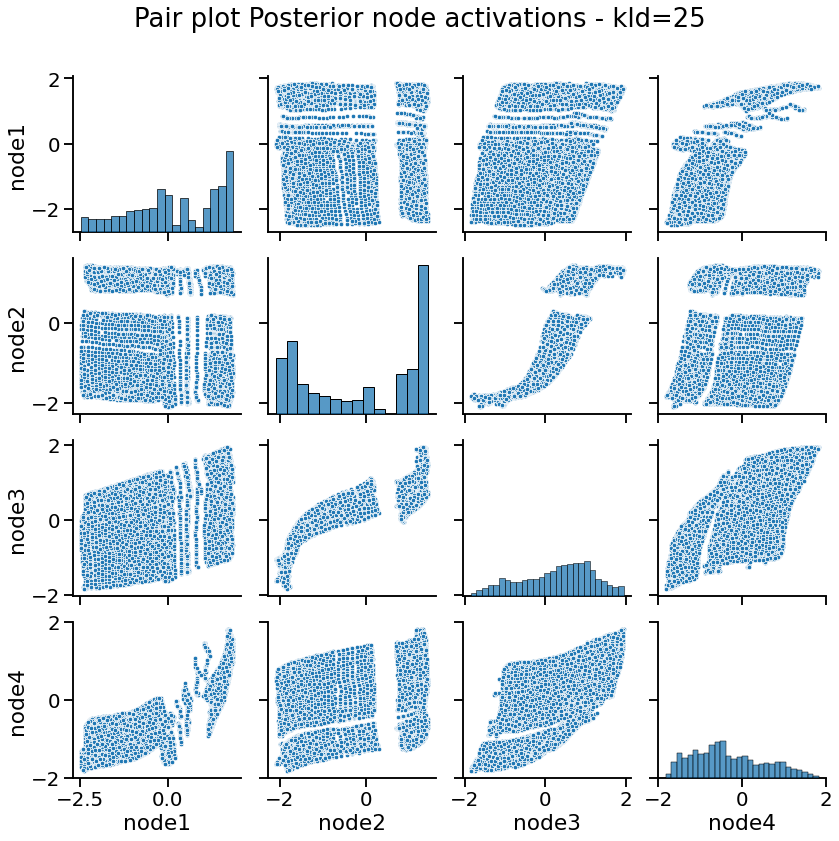

In [106]:
# plot prior activations
# suppress the feat_dim dimension from (b,V,feat_dim) assuming it has only 1-dim
activations = mu_batches.squeeze(2)
activations_df = pd.DataFrame(activations, columns=["node1","node2","node3","node4"])
activations_df.head()
sns_plot = sns.pairplot(activations_df, markers=".", height=3.0)
sns_plot.fig.suptitle("Pair plot Posterior node activations - kld=25")
sns_plot.fig.subplots_adjust(top=0.9)

In [109]:
A=torch.arange(20).reshape(5,4,1)

In [110]:
A.ndim

3